In [1]:
%pylab inline

import os
import anacal
import numpy as np

try:
    get_ipython().run_line_magic("matplotlib", "inline")
except NameError:
    # Not running in Jupyter, so skip the magic command
    import matplotlib
    matplotlib.use("Agg")
from astropy.visualization import simple_norm
import matplotlib.pylab as plt
import galsim

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
npix = 256
pixel_scale = 0.04  # LSST image pixel scale
# noise variance for r-bands 10 year LSST coadd (magnitude zero point at 30)
noise_std = 0.37 / 25.0
noise_variance = noise_std**2.0
noise_array = None
seed = 1

psf_obj = galsim.Moffat(beta=2.5, fwhm=0.242)
psf_array = (
    psf_obj.shift(0.5 * pixel_scale, 0.5 * pixel_scale)
    .drawImage(nx=128, ny=128, scale=pixel_scale)
    .array
)

# shear distortion setupsl
# note that there are three options in each redshift bin
# 0: g=-0.02; 1: g=0.02; 2: g=0.00
# for example, number of redshift bins is 4, (nz_bins = [0., 0.5, 1.0,
# 1.5, 2.0]) if mode = 7 which in ternary is "0021" --- meaning that
# the shear is (-0.02, -0.02, 0.00, 0.02) in each bin, respectively.
gname = "g1-1"
n_multi_x = 10
n_multi_y = 10

gal_array, gal_cat = anacal.simulation.make_isolated_sim(
    gal_type="mixed",
    sim_method="fft",
    psf_obj=psf_obj,
    gname=gname,
    seed=seed,
    ngrid=npix,
    ny=npix * n_multi_x,
    nx=npix * 2 * n_multi_y,
    scale=pixel_scale,
    do_shift=False,
    buff=0,
    nrot_per_gal=2,
    mag_zero=30,
    return_catalog=True,
)
gal_array = gal_array[0]

In [3]:
# Force detections at the centers
indx = np.arange(npix // 2, npix * 2 * n_multi_x, npix)
indy = np.arange(npix // 2, npix * n_multi_y, npix)
ns = len(indx) * len(indy)
inds = np.meshgrid(indy, indx, indexing="ij")
yx = np.vstack([np.ravel(_) for _ in inds])
dtype = np.dtype(
    [
        ("y", np.int32),
        ("x", np.int32),
    ]
)
detection = np.empty(ns, dtype=dtype)
detection["y"] = yx[0]
detection["x"] = yx[1]


# Do measurement
fpfs_config = anacal.fpfs.FpfsConfig(
    sigma_shapelets=0.45,  # The first measurement scale (also for detection)
    omega_v=0.4,
    v_min=0.0,
    npix=128,
)
catalog = anacal.fpfs.process_image(
    fpfs_config=fpfs_config,
    mag_zero=30.0,
    gal_array=gal_array,
    psf_array=psf_array,
    pixel_scale=pixel_scale,
    noise_variance=noise_variance,
    noise_array=noise_array,
    detection=detection,
)

print(len(catalog))

e1 = catalog["fpfs_w"] * catalog["fpfs_e1"]
e1g1 = (
    catalog["fpfs_dw_dg1"] * catalog["fpfs_e1"]
    + catalog["fpfs_w"] * catalog["fpfs_de1_dg1"]
)

mbias = np.sum(e1) / np.sum(e1g1) / 0.02 - 1  # 0.02 is the input shear

print(mbias)


e1 = catalog["fpfs_e1"]
e1g1 = catalog["fpfs_de1_dg1"]

mbias = np.sum(e1) / np.sum(e1g1) / 0.02 - 1  # 0.02 is the input shear

print(mbias)

200
0.00017167747417046186
0.00022628925436740666


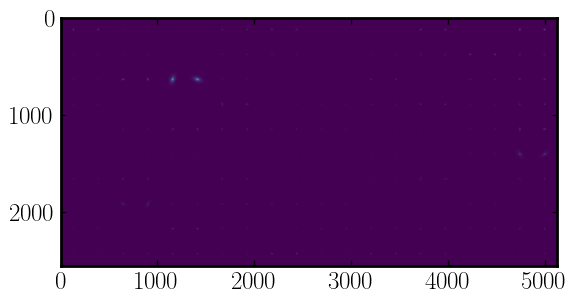

In [4]:
plt.imshow(gal_array)

In [5]:
npix = 64
pixel_scale = 0.04  # LSST image pixel scale
# noise variance for r-bands 10 year LSST coadd (magnitude zero point at 30)
noise_std = 0.37 / 25.0
noise_variance = noise_std**2.0
noise_array = None
seed = 1

psf_obj = galsim.Moffat(beta=2.5, fwhm=0.242)
psf_array = (
    psf_obj.shift(0.5 * pixel_scale, 0.5 * pixel_scale)
    .drawImage(nx=npix, ny=npix, scale=pixel_scale)
    .array
)

# shear distortion setupsl
# note that there are three options in each redshift bin
# 0: g=-0.02; 1: g=0.02; 2: g=0.00
# for example, number of redshift bins is 4, (nz_bins = [0., 0.5, 1.0,
# 1.5, 2.0]) if mode = 7 which in ternary is "0021" --- meaning that
# the shear is (-0.02, -0.02, 0.00, 0.02) in each bin, respectively.
gname = "g1-1"
n_multi_x = 50
n_multi_y = 50

gal_array, gal_cat = anacal.simulation.make_isolated_sim(
    gal_type="mixed",
    sim_method="fft",
    psf_obj=psf_obj,
    gname=gname,
    seed=seed,
    ngrid=npix,
    ny=npix * n_multi_x,
    nx=npix * 2 * n_multi_y,
    scale=pixel_scale,
    do_shift=False,
    buff=0,
    nrot_per_gal=4,
    mag_zero=30,
    return_catalog=True,
)
gal_array = gal_array[0]


# Force detections at the centers
indx = np.arange(npix // 2, npix * 2 * n_multi_x, npix)
indy = np.arange(npix // 2, npix * n_multi_y, npix)
ns = len(indx) * len(indy)
inds = np.meshgrid(indy, indx, indexing="ij")
yx = np.vstack([np.ravel(_) for _ in inds])
dtype = np.dtype(
    [
        ("y", np.int32),
        ("x", np.int32),
    ]
)
detection = np.empty(ns, dtype=dtype)
detection["y"] = yx[0]
detection["x"] = yx[1]

In [6]:
# Do measurement
fpfs_config = anacal.fpfs.FpfsConfig(
    sigma_shapelets=0.45,  # The first measurement scale (also for detection)
    npix=npix,
)
catalog = anacal.fpfs.process_image(
    fpfs_config=fpfs_config,
    mag_zero=30.0,
    gal_array=gal_array,
    psf_array=psf_array,
    pixel_scale=pixel_scale,
    noise_variance=noise_variance,
    noise_array=noise_array,
    detection=detection,
    only_return_detection_modes=True,
)
w0 = anacal.fpfs.measure_fpfs_wdet0(
    v_min=0.0, omega_v=0.4, x_array=catalog["data"]
)["w"]
# plt.hist(w0, bins=50, range=(0.0, 1))

In [7]:
# plt.hist(catalog["data"]["v1"], bins=50, range=(0.0, 1))